In [5]:
!pip install -q tqdm

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

In [45]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])

test_val_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load full training dataset with transform for splitting
full_train_dataset = datasets.CIFAR10(root="./cifar10", train=True, download=True, transform=train_transform)

# Split into train and val
train_len = int(0.7 * len(full_train_dataset))
val_len = len(full_train_dataset) - train_len
train_set, val_set = random_split(full_train_dataset, [train_len, val_len])

# Replace transform for validation set
val_set.dataset = datasets.CIFAR10(root="./cifar10", train=True, download=False, transform=test_val_transform)

# Load test set
test_dataset = datasets.CIFAR10(root="./cifar10", train=False, download=True, transform=test_val_transform)

# DataLoaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [46]:
class OD_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(OD_CNN, self).__init__()
        self.features = nn.Sequential(
            # Layer 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),      
            nn.Dropout2d(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),      
            nn.Dropout2d(0.3),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            # Layer 6
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),      
            nn.Dropout2d(0.2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4096, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OD_CNN(num_classes=10).to(device)

In [48]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [51]:
num_epochs = 30
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_running_loss = 0.0
    correct_val, total_val = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss = val_running_loss / len(val_loader)
    val_acc = correct_val / total_val
    val_losses.append(val_loss)

    scheduler.step()

    print(f"Epoch {epoch+1}: "
          f"Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}, "
          f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

Epoch 1/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.07it/s]


Epoch 1: Train Loss = 0.8626, Train Acc = 0.8556, Val Loss = 0.7892, Val Acc = 0.8866


Epoch 2/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.04it/s]


Epoch 2: Train Loss = 0.8573, Train Acc = 0.8581, Val Loss = 0.7847, Val Acc = 0.8885


Epoch 3/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.14it/s]


Epoch 3: Train Loss = 0.8523, Train Acc = 0.8593, Val Loss = 0.7894, Val Acc = 0.8880


Epoch 4/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.71it/s]


Epoch 4: Train Loss = 0.8449, Train Acc = 0.8635, Val Loss = 0.7842, Val Acc = 0.8876


Epoch 5/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.75it/s]


Epoch 5: Train Loss = 0.8427, Train Acc = 0.8665, Val Loss = 0.7812, Val Acc = 0.8915


Epoch 6/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.43it/s]


Epoch 6: Train Loss = 0.8375, Train Acc = 0.8654, Val Loss = 0.7806, Val Acc = 0.8909


Epoch 7/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.86it/s]


Epoch 7: Train Loss = 0.8401, Train Acc = 0.8648, Val Loss = 0.7783, Val Acc = 0.8939


Epoch 8/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.62it/s]


Epoch 8: Train Loss = 0.8355, Train Acc = 0.8687, Val Loss = 0.7759, Val Acc = 0.8939


Epoch 9/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.52it/s]


Epoch 9: Train Loss = 0.8326, Train Acc = 0.8690, Val Loss = 0.7812, Val Acc = 0.8907


Epoch 10/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.75it/s]


Epoch 10: Train Loss = 0.8254, Train Acc = 0.8716, Val Loss = 0.7782, Val Acc = 0.8913


Epoch 11/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.76it/s]


Epoch 11: Train Loss = 0.8159, Train Acc = 0.8767, Val Loss = 0.7696, Val Acc = 0.8958


Epoch 12/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.53it/s]


Epoch 12: Train Loss = 0.8123, Train Acc = 0.8790, Val Loss = 0.7680, Val Acc = 0.8965


Epoch 13/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.10it/s]


Epoch 13: Train Loss = 0.8096, Train Acc = 0.8811, Val Loss = 0.7659, Val Acc = 0.8967


Epoch 14/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.70it/s]


Epoch 14: Train Loss = 0.8133, Train Acc = 0.8793, Val Loss = 0.7642, Val Acc = 0.8987


Epoch 15/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.51it/s]


Epoch 15: Train Loss = 0.8045, Train Acc = 0.8835, Val Loss = 0.7614, Val Acc = 0.8988


Epoch 16/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.34it/s]


Epoch 16: Train Loss = 0.8040, Train Acc = 0.8822, Val Loss = 0.7627, Val Acc = 0.8987


Epoch 17/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.00it/s]


Epoch 17: Train Loss = 0.8015, Train Acc = 0.8851, Val Loss = 0.7603, Val Acc = 0.9016


Epoch 18/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.39it/s]


Epoch 18: Train Loss = 0.8013, Train Acc = 0.8828, Val Loss = 0.7599, Val Acc = 0.9013


Epoch 19/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.63it/s]


Epoch 19: Train Loss = 0.7973, Train Acc = 0.8870, Val Loss = 0.7626, Val Acc = 0.8995


Epoch 20/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.98it/s]


Epoch 20: Train Loss = 0.7971, Train Acc = 0.8849, Val Loss = 0.7589, Val Acc = 0.9007


Epoch 21/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.58it/s]


Epoch 21: Train Loss = 0.7923, Train Acc = 0.8871, Val Loss = 0.7554, Val Acc = 0.9024


Epoch 22/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.44it/s]


Epoch 22: Train Loss = 0.7905, Train Acc = 0.8893, Val Loss = 0.7547, Val Acc = 0.9022


Epoch 23/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.84it/s]


Epoch 23: Train Loss = 0.7895, Train Acc = 0.8905, Val Loss = 0.7539, Val Acc = 0.9027


Epoch 24/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.29it/s]


Epoch 24: Train Loss = 0.7850, Train Acc = 0.8911, Val Loss = 0.7528, Val Acc = 0.9019


Epoch 25/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.45it/s]


Epoch 25: Train Loss = 0.7860, Train Acc = 0.8907, Val Loss = 0.7545, Val Acc = 0.9023


Epoch 26/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 85.94it/s]


Epoch 26: Train Loss = 0.7825, Train Acc = 0.8938, Val Loss = 0.7500, Val Acc = 0.9054


Epoch 27/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 86.98it/s]


Epoch 27: Train Loss = 0.7803, Train Acc = 0.8933, Val Loss = 0.7531, Val Acc = 0.9029


Epoch 28/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 87.92it/s]


Epoch 28: Train Loss = 0.7814, Train Acc = 0.8928, Val Loss = 0.7500, Val Acc = 0.9044


Epoch 29/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.69it/s]


Epoch 29: Train Loss = 0.7806, Train Acc = 0.8942, Val Loss = 0.7523, Val Acc = 0.9043


Epoch 30/30 - Validation: 100%|██████████| 235/235 [00:02<00:00, 88.16it/s]

Epoch 30: Train Loss = 0.7771, Train Acc = 0.8967, Val Loss = 0.7507, Val Acc = 0.9051


Testing: 100%|██████████| 157/157 [00:01<00:00, 89.21it/s]



Test Accuracy: 90.31%

Classification Report:
              precision    recall  f1-score   support

    airplane       0.91      0.91      0.91      1000
  automobile       0.95      0.96      0.96      1000
        bird       0.89      0.86      0.88      1000
         cat       0.85      0.74      0.79      1000
        deer       0.89      0.92      0.90      1000
         dog       0.82      0.87      0.85      1000
        frog       0.93      0.93      0.93      1000
       horse       0.93      0.94      0.94      1000
        ship       0.94      0.95      0.94      1000
       truck       0.92      0.95      0.93      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



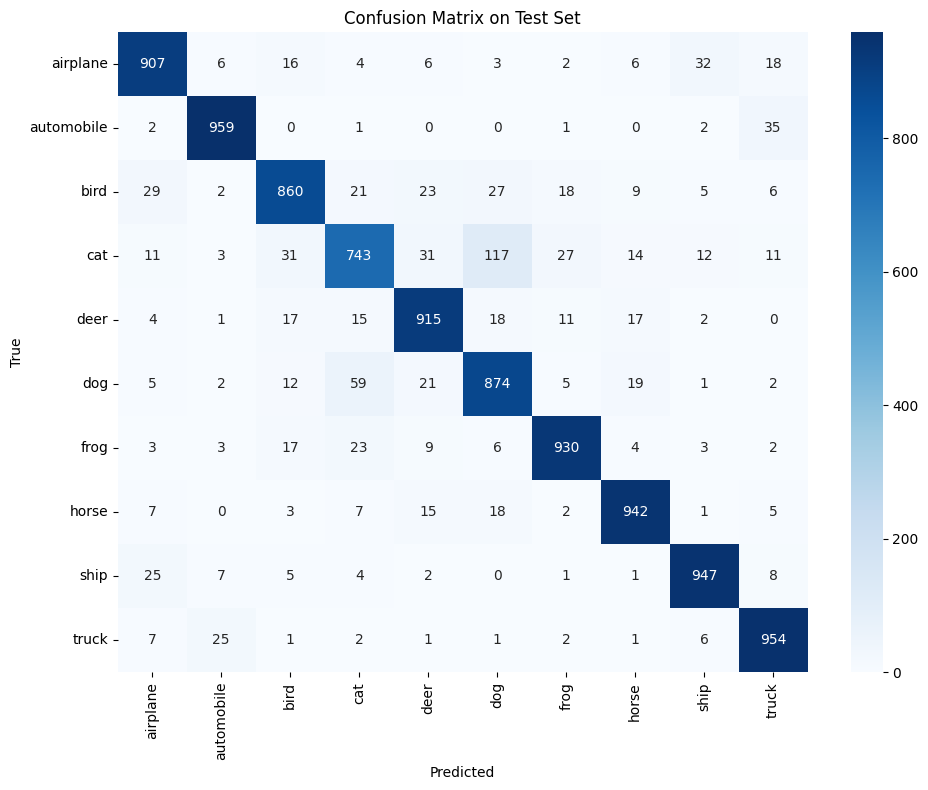

In [52]:
def evaluate_on_testset(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"\nTest Accuracy: {accuracy:.2f}%")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_targets, all_preds, target_names=test_dataset.classes))

    # Confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    plt.title("Confusion Matrix on Test Set")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

#  Call this after training
evaluate_on_testset(model, test_loader, device)


In [53]:
torch.save(model.state_dict(), 'cnn_model.pth')

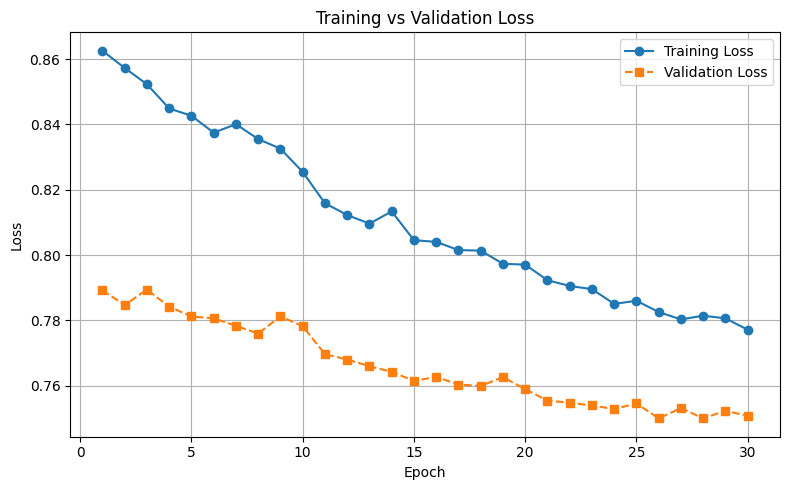

In [54]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, val_losses, label='Validation Loss', marker='s', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
